In [1]:
import pandas as pd
import time
start=time.time()
df = pd.read_csv('Italian.csv') # Load the ratings and is_open data from the CSV file
ending=time.time()
print(ending-start) #Takes less than a second to load. MySQL already did the heavy lifting, filtering 3 million records to 40k.
#This is important because I found pandas to be 10x or more slower than SQL. So a combination of both is the best!

0.08398008346557617


In [2]:
df.head() #Take a quick look at the data. Pandas provides these routines that are excellent for loading/viewing data

,business_id,date,stars,is_open
0,QdN72BWoyFypdGJhhI5r7g,2016-11-10,5.0,0
1,TttFjRQ-8Iz8by4hsD7iOQ,2017-11-06,5.0,1
2,afsP-p_pr4ikrboB5MtUzQ,2017-04-19,5.0,1
3,rVfe1LHo55A2fworkm_jVw,2017-02-19,5.0,0
4,rVfe1LHo55A2fworkm_jVw,2017-02-19,4.0,0


In [3]:
import numpy as np
from datetime import datetime, date
count=0 #Number of rows throwing Exception
isopen=dict()
avgstars=dict()
numrevs=dict()
earliest=dict()
mostrecent=dict()
for j in range(len(df)):
    try:
        bid=df.iloc[j,0]   
        dated=(datetime.strptime(df.iloc[j,1], "%Y-%m-%d")).date() #Parse the date
        if not bid in isopen:
            isopen[bid]=op=df.iloc[j,3]
            earliest[bid]=dated
            mostrecent[bid]=dated
            avgstars[bid]=df.iloc[j,2]
            numrevs[bid]=1
        else:
            numrevs[bid]+=1
            avgstars[bid]+=df.iloc[j,2]
            # Update dates
            prev=earliest[bid]
            if prev>dated:
                earliest[bid] = dated 
            prev=mostrecent[bid]
            if prev<dated:
                mostrecent[bid] = dated 
    except Exception as e:
        count+=1
        continue #Skip this review
        
#Finally need to calculate average rating
for bid in avgstars:
    avgstars[bid]=avgstars[bid]/numrevs[bid]

In [4]:
print(j)
print(count) #Relatively few bad records. We can just skip them.

40059
183


In [5]:
import matplotlib.pyplot as plt
r=list() #Turn dictionary into array
ope=list()
a=list()
for bid in isopen:
    ea=earliest[bid]
    mr=mostrecent[bid]
    duration=((mr-ea).days) #Estimate how long they've been open in years
    #skip businesses less than 1 years old    
    if ((date.today()-ea).days) < 5 * 365 or duration<1: 
        continue
    temp=numrevs[bid] #Save the value, to avoid looking up multiple times. I guess doesn't matter cause dictionary is O(1) lol
    r.append(temp)
    ope.append(duration/365>5)
    a.append(avgstars[bid])       
rr=np.array(r)
aa=np.array(a)
penn=np.array(ope)

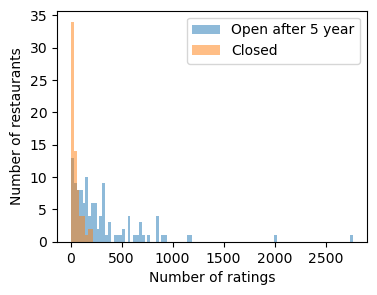

In [18]:
#With the data processed, let's do some exploratory data analysis
plt.figure(figsize=(4, 3))
plt.hist(rr[penn==1],100,label='Open after 5 year',alpha=0.5) #Keep the default colors since it's color-blind friendly
plt.hist(rr[penn==0],8,label='Closed',alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Number of ratings')
plt.ylabel('Number of restaurants')
plt.show() #We see that restaurants that are still open after 5 years generally have higher reviews. Makes sense, cool.  

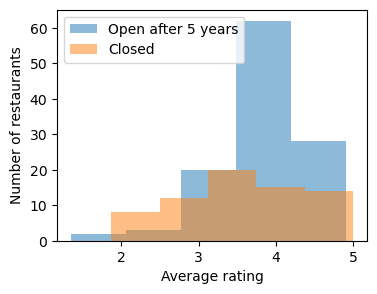

In [19]:
plt.figure(figsize=(4, 3))
plt.hist(aa[penn==1],5,alpha=0.5,label='Open after 5 years')
plt.hist(aa[penn==0],5,alpha=0.5,label='Closed')
plt.legend(loc='upper left')
plt.ylabel('Number of restaurants')
plt.xlabel('Average rating')
plt.show() #We see that succesful business have on average higher ratings, as expected. Makes sense. 
#We need to make sure the data is making sense before we waste time with machine learning etc. Have to walk before you run, lol. 

In [42]:
print(len(aa[penn==1])) #Print how many open vs. closed, respectively
print(len(aa[penn==0]))

115
69


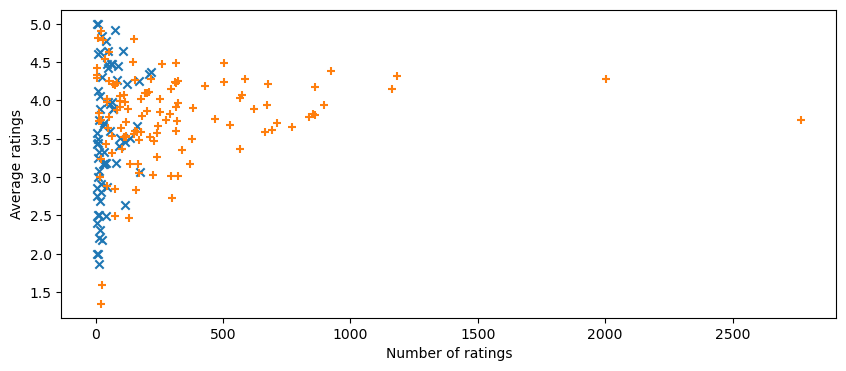

In [48]:
plt.figure(figsize=(10, 4)) #Try to plot the data...
plt.scatter(rr[penn==0],aa[penn==0],marker='x')
plt.scatter(rr[penn==1],aa[penn==1],marker='+')
plt.xlabel('Number of ratings')
plt.ylabel('Average ratings')
plt.show() #It's interesting that the x-axis has some far-away points and some "jumbled-up" close to zero points... 

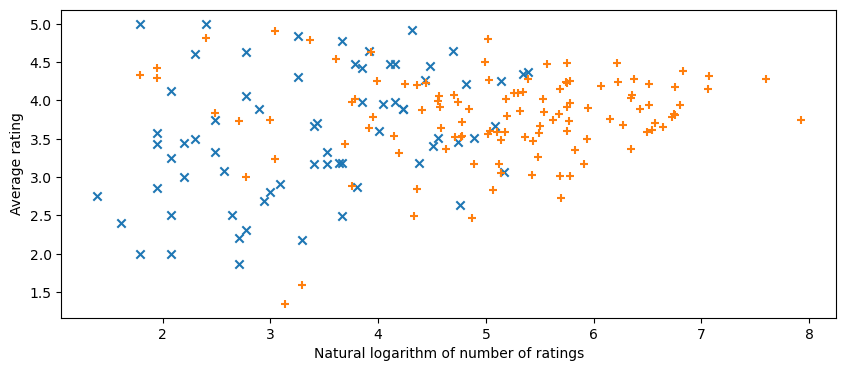

In [49]:
plt.figure(figsize=(10, 4)) #Let's try a semi-log plot, see if that makes it visually better...
plt.scatter(np.log(rr[penn==0]),aa[penn==0],marker='x')
plt.scatter(np.log(rr[penn==1]),aa[penn==1],marker='+')
plt.xlabel('Natural logarithm of number of ratings')
plt.ylabel('Average rating')
plt.show() #Ah look at that! Far more visually clear! That's interesting, number of ratings seems like a logarithmic phenomenon.

In [57]:
#Time to define machine learning classification model. We will use logistic regression.
#We will write this from scratch instead of just using sci-kit learn. The advantage is we know exactly what is going 
#on "under the hood". This approach is inspired by Andrew Ng's ML course. 
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        # Initialize weights as a array of ones of length 7; 2 independent variables, and 5 engineered going upto cubic
        # 7 seems like a decent choice between under and over-fitting, after my experimentations
        self.weights = [0] * 7  
        self.bias = 0
        self.cost_history = []  # List to store cost at each iteration
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
         
    def _compute_cost(self, y, h):
        cost = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost
    
    def _optimize(self, Xset, yset):
        m = Xset.shape[0]
        print(f"Sample size: {m}") #Print the sample size when you begin
        for i in range(self.num_iterations):
            cost=0
            dw=0
            db=0
            for j in range(m):
                # Forward propagation
                linear_model = np.dot(Xset[j], self.weights) + self.bias
                h = self._sigmoid(linear_model)                
                # Compute cost for tracking
                cost += self._compute_cost(yset[j], h)/m
                temp=h - yset[j]             
                # Compute gradient
                dw +=  temp * Xset[j] 
                db += h - yset[j]
 
            dw=dw/m
            db=db/m
            self.cost_history.append(cost)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Print cost every 100 iterations (or another interval of your choice)
            if i % 10000 == 0:
                print(f"Iteration {i}: Cost {cost}")
    
    def fit(self, X, y):
        # Optimize parameters using gradient descent
        self._optimize(X, y)
        print("Final weights:", self.weights)
        print("Final bias:", self.bias)
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        h = self._sigmoid(linear_model)
        y_pred = np.where(h > 0.5, 1, 0)
        return y_pred

In [59]:
# Calculate 70% of the array length. This is for training the model. The remaining 30% will be used to test accuracy later.
sample_size = int(len(rr) * 0.7)

# Randomly sample 70% of the array
sampled_array = np.random.choice(range(len(rr)), size=sample_size, replace=False)

# 2 independent variables (average rating and log of number of ratings)
# 5 additional engineered features, going up to cubic, inclduing one "mixed" feature. 
# After experimentation, this seems like good balance between over and underfitting, and also gives good accuracy, 77%.
X_train = np.zeros([sample_size, 7])
y_train = np.zeros([sample_size, 1])
X_train[:,0]=np.log(rr[sampled_array])
X_train[:,1]=aa[sampled_array]
minnumrevs=min(X_train[:,0])
minavgrevs=min(X_train[:,1])
X_train[:,0]=X_train[:,0]-minnumrevs #Min-max normalization. Seems to work great.
X_train[:,1]=X_train[:,1]-minavgrevs
maxnumrevs=max(X_train[:,0])
maxavgrevs=max(X_train[:,1])
X_train[:,0]=X_train[:,0]/maxnumrevs
X_train[:,1]=X_train[:,1]/maxavgrevs
X_train[:,2]=X_train[:,0]**2
X_train[:,3]=X_train[:,1]**2
X_train[:,4]=X_train[:,0]*X_train[:,1]
X_train[:,5]=X_train[:,0]**3
X_train[:,6]=X_train[:,1]**3
y_train=penn[sampled_array]
lr = LogisticRegression(learning_rate=0.5, num_iterations=100000) #Pick a high enough iteration number so that cost stabilizes
start=time.time() #But not so high that we get overfitting or takes too long to fit.
lr.fit(X_train, y_train)
ending=time.time()
print(ending-start) #Takes less than 10 minutes

Sample size: 128
Iteration 0: Cost 0.6931471805599462
Iteration 10000: Cost 0.41068312338270263
Iteration 20000: Cost 0.4063966244504797
Iteration 30000: Cost 0.40463390393535553
Iteration 40000: Cost 0.4032715085593811
Iteration 50000: Cost 0.4020558571772582
Iteration 60000: Cost 0.4009370045662661
Iteration 70000: Cost 0.39989762803573564
Iteration 80000: Cost 0.3989288852477668
Iteration 90000: Cost 0.3980250406870043
Final weights: [  3.74472104  -3.60330757   7.94378008  19.11447452 -12.1648239
  12.50718707 -12.89964492]
Final bias: -2.7539706090238316
469.12031865119934


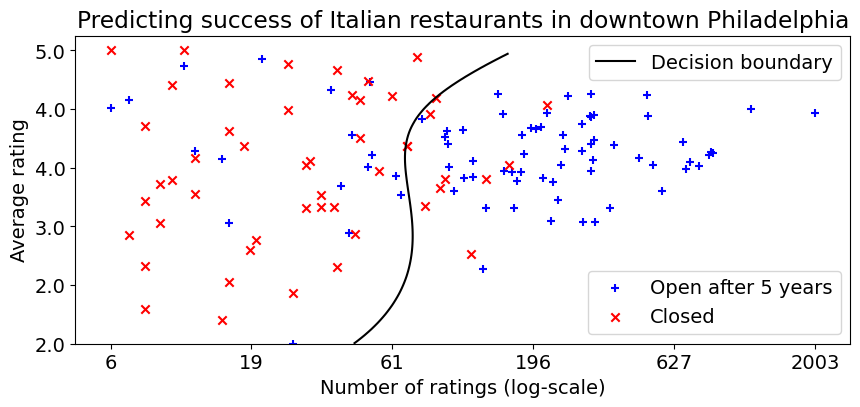

In [61]:
#Code to get the final plot with decision boundary to look just right. Important to display results as nicely as possible.
from matplotlib.lines import Line2D  # For custom legend entries
plt.figure(figsize=(10, 4))
#I'm going to switch to red and blue colors here cause it really makes the figure pop.
#Color-blind people will have to study the chart by distinguishing the markers 
p1=plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1],marker='+',label='Open after 5 years',color='blue')
plt.scatter(X_train[y_train==0,0],X_train[y_train==0,1],marker='x',label='Closed',color='red')
xx, yy = np.meshgrid(np.arange(0.2, .8, 0.01), np.arange(0, 1, 0.01))
w=lr.weights
zz=w[0]*xx + w[1]*yy + w[2]*(xx**2) + w[3]*(yy**2) + w[4]*(yy*xx) + lr.bias  + w[5]*(xx**3) + w[6]*(yy**3)
contours=plt.contour(xx,yy,zz,levels=0,colors='black')
legend_entries = []
for level in contours.levels:
    legend_entries.append(Line2D([0], [0], color='black', label='Decision boundary'))
    break

ax = plt.gca()  # Get the current axis
xtiks=[0, 0.2, 0.4, 0.6, 0.8, 1 ]
ax.set_xticks(xtiks)  # Replace with the desired tick positions
newxtiks=np.zeros((6,1))
#The key here is to reverse the min-max normalization so that readers can easily read-off the actual numbers. A key step.
for j in range(len(xtiks)):
    newxtiks[j]=np.exp((xtiks[j]*maxnumrevs)+minnumrevs)
newxtiks=(np.rint(newxtiks))
ax.set_xticklabels([str(int(newxtiks[0,0])), str(int(newxtiks[1,0])), str(int(newxtiks[2,0])),str(int(newxtiks[3,0])),str(int(newxtiks[4,0])),str(int(newxtiks[5,0]))])

ytiks=[0, 0.2, 0.4, 0.6, 0.8, 1 ]
ax.set_yticks(ytiks)  # Replace with the desired tick positions
newytiks=np.zeros((6,1))
for j in range(len(ytiks)):
    newytiks[j]=(ytiks[j]*maxavgrevs)+minavgrevs
newytiks=(np.rint(newytiks))
ax.set_yticklabels([str(newytiks[0,0]), str(newytiks[1,0]), str(newytiks[2,0]),str(newytiks[3,0]),str(newytiks[4,0]),str(newytiks[5,0])])
plt.xlabel('Number of ratings (log-scale)')
plt.ylabel('Average rating')
first_legend=plt.legend(loc='lower right')
plt.rcParams['font.size'] = 14
plt.title('Predicting success of Italian restaurants in downtown Philadelphia')
ax.add_artist(first_legend)
plt.legend(handles=legend_entries, loc='upper right')
plt.show()

In [62]:
#Finally, let's estimate accuracy of the trained model by checking against remaining 30% of data
count=0 #Count number of test points
correct=0 #Count number of "Correct" predictions

for j in range(len(rr)): #First gather the test data
    if j not in sampled_array:
        count+=1
        X0=(np.log(rr[j])-minnumrevs)/maxnumrevs #Apply normalization
        X1=(aa[j]-minavgrevs)/maxavgrevs
        X2=X0**2
        X3=X1**2
        X4=X0*X1
        X5=X0**3
        X6=X1**3
        prediction=lr.predict([X0,X1,X2,X3,X4,X5,X6])
        if prediction==penn[j]:
            correct+=1
print(correct/count)
        

0.75
